# 本程序用于分析往届《结构力学（2）》的成绩

In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt


path = "./"
files = os.listdir(path)

定义读入文件生成 DataFrame 的函数

In [2]:
# 定义读入单个文件生成 DataFrame 的函数
def readFile(fileName):
    df = pd.read_csv(fileName, sep="\t")
    return df


# 定义读入全部文件生成 DataFrame 的函数
def readFiles(files):
    df = pd.DataFrame()
    for file in files:
        # 判断文件是否以 .txt 结尾
        if file.endswith(".txt"):
            df = pd.concat([df, readFile(file)])
    return df

In [3]:
# 输入1：读入指定文件名的文件，输入2：读入全部文件，输入其他内容退出程序
def main():
    print("输入1：读入指定文件名的文件，输入2：读入全部文件，输入其他内容退出程序")
    choice = input()
    if choice == "1":
        fileName = input("请输入文件名：") + ".txt"
        df = readFile(fileName)
    elif choice == "2":
        df = readFiles(files)
    else:
        exit()
    return df


df = main()

输入1：读入指定文件名的文件，输入2：读入全部文件，输入其他内容退出程序


In [4]:
# 重新生成 index 从 0 开始
df = df.reset_index(drop=True)
len1 = len(df)
# 清洗数据
# 去除”期末成绩“不是数字的行
df = df[pd.to_numeric(df["期末成绩"], errors="coerce").notnull()]
# 将”期末成绩“、”平时成绩“、”最终成绩“转换为数值型
df["期末成绩"] = pd.to_numeric(df["期末成绩"], errors="coerce")
df["平时成绩"] = pd.to_numeric(df["平时成绩"], errors="coerce")
df["最终成绩"] = pd.to_numeric(df["最终成绩"], errors="coerce")
len2 = len(df)
print(f"初始数据一共有 {len1} 条，清洗后一共有 {len2} 条数据")

初始数据一共有 771 条，清洗后一共有 766 条数据


In [5]:
# 当前有效成绩总数
print(f"当前有效成绩共 {len2} 条记录")
# 列出平时成绩平均值和标准差，列出总评成绩平均值和标准差，列出最终成绩平均值和标准差
print(
    f"平时成绩：平均值 = {df["平时成绩"].mean():.2f}, 标准差 = {df["平时成绩"].std():.2f}"
)
print(
    f"期末成绩：平均值 = {df["期末成绩"].mean():.2f}, 标准差 = {df["期末成绩"].std():.2f}"
)
print(
    f"最终成绩：平均值 = {df["最终成绩"].mean():.2f}, 标准差 = {df["最终成绩"].std():.2f}"
)

当前有效成绩共 766 条记录
平时成绩：平均值 = 82.69, 标准差 = 14.69
期末成绩：平均值 = 75.58, 标准差 = 17.12
最终成绩：平均值 = 77.76, 标准差 = 15.64


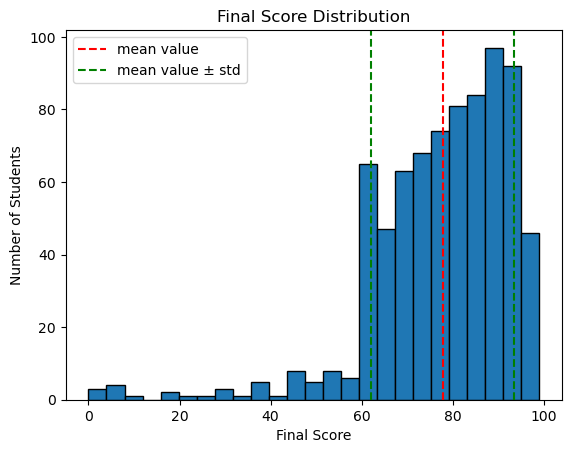

In [10]:
# 绘制最终成绩直方图，显示均值、方差、标准差
plt.hist(df["最终成绩"], bins=25, edgecolor="black")
plt.xlabel("Final Score")
plt.ylabel("Number of Students")
plt.title("Final Score Distribution")
plt.axvline(df["最终成绩"].mean(), color="red", linestyle="--", label="mean value")
plt.axvline(
    df["最终成绩"].mean() + df["最终成绩"].std(),
    color="green",
    linestyle="--",
    label="mean value ± std",
)
plt.axvline(df["最终成绩"].mean() - df["最终成绩"].std(), color="green", linestyle="--")
plt.legend()
plt.show()